In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [10]:
features = [
    # Numerical features
    "store_nbr", "item_nbr", "transactions", "dcoilwtico", "dayofweek",
    "is_weekend", "lag_7", "rolling_7", "promo_lag_interaction",
    
    # One-hot encoded categorical features
    "type_y_Work Day",  # Only one category found; check if more exist
    
    # All one-hot encoded 'family' features
    "family_BEAUTY", "family_BEVERAGES", "family_BREAD/BAKERY", "family_CLEANING",
    "family_DAIRY", "family_DELI", "family_EGGS", "family_FROZEN FOODS", "family_GROCERY I",
    "family_GROCERY II", "family_HARDWARE", "family_HOME APPLIANCES", "family_LAWN AND GARDEN",
    "family_LINGERIE", "family_LIQUOR,WINE,BEER", "family_MEATS", "family_PERSONAL CARE",
    "family_POULTRY", "family_PREPARED FOODS", "family_SEAFOOD",

    # All one-hot encoded 'city' features
    "city_Babahoyo", "city_Cayambe", "city_Cuenca", "city_Daule", "city_El Carmen",
    "city_Esmeraldas", "city_Guaranda", "city_Guayaquil", "city_Ibarra", "city_Latacunga",
    "city_Loja", "city_Machala", "city_Playas", "city_Quevedo", "city_Quito", "city_Riobamba",
    "city_Salinas", "city_Santo Domingo",

    # All one-hot encoded 'state' features
    "state_Bolivar", "state_Chimborazo", "state_Cotopaxi", "state_El Oro", "state_Esmeraldas",
    "state_Guayas", "state_Imbabura", "state_Loja", "state_Los Rios", "state_Manabi",
    "state_Pichincha", "state_Santa Elena", "state_Santo Domingo de los Tsachilas", "state_Tungurahua"
]

target = "unit_sales"

# Selecting the data
X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

X_test = test_df[features]


In [11]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [12]:
params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',  # Root Mean Squared Error (RMSE)
    'eta': 0.1,  # Learning rate
    'max_depth': 6,  # Maximum depth of a tree
    'subsample': 0.8,  # Fraction of data used for training trees
    'colsample_bytree': 0.8,  # Fraction of features used for each tree
    'lambda': 1,  # L2 regularization term
    'alpha': 0,  # L1 regularization term
    'n_jobs': -1,  # Use all available cores
    'seed': 42  # Random seed for reproducibility
}

# Train the model
num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Stop if no improvement for 50 rounds

evals = [(dtrain, 'train'), (dval, 'eval')]  # Evaluation set for validation during training

model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=100)


[0]	train-rmse:17.10502	eval-rmse:20.63510
[100]	train-rmse:8.83035	eval-rmse:11.84128
[200]	train-rmse:8.02176	eval-rmse:11.59477
[300]	train-rmse:7.49506	eval-rmse:11.48208
[400]	train-rmse:7.09086	eval-rmse:11.40517
[446]	train-rmse:6.95806	eval-rmse:11.40600


In [13]:
# Make predictions
y_pred_train = model.predict(dtrain)
y_pred_val = model.predict(dval)


In [19]:
from sklearn.metrics import root_mean_squared_error
rmse_val = root_mean_squared_error(y_val, y_pred_val)



# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

print("Training MAE:", mae_train)
print("Training RMSE:", rmse_train)
print("Validation MAE:", mae_val)
print("Validation RMSE:", rmse_val)

Training MAE: 4.185408278181785
Training RMSE: 6.955854580796997
Validation MAE: 5.298474285344378
Validation RMSE: 11.40418488180517


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
#Predict on test set

dtest = xgb.DMatrix(test_df[features])
y_pred_test = model.predict(dtest)

# Evaluate the test set
y_test = test_df[target]
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)

Test MAE: 5.389450019318643
Test RMSE: 12.072501107264166


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


NameError: name 'plt' is not defined

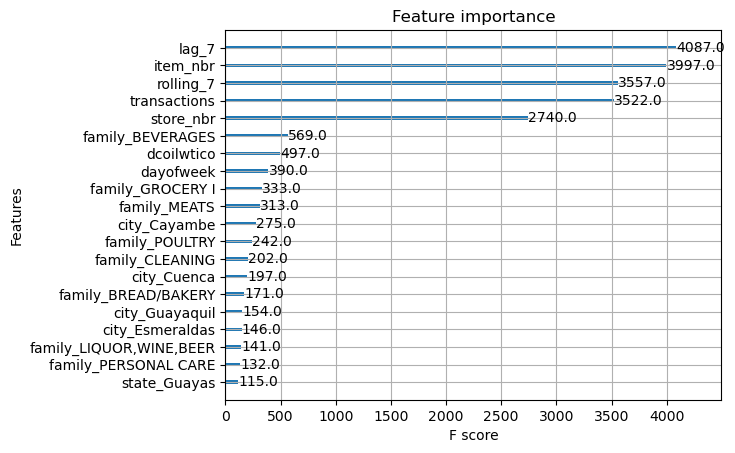

In [21]:
#feature importance plot

xgb.plot_importance(model, max_num_features=20, importance_type="weight")  # Adjust number of features if needed
plt.show()

In [22]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid=params, cv=3, scoring="neg_mean_absolute_error", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Params:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1.0}
